In [1]:
# Configs
train_dir = r'datasets\Grambedding\test.csv'
test_dir = r'datasets\Grambedding\train.csv'

In [2]:
# from IPython.display import clear_output
# !pip install transformers datasets torch evaluate
# clear_output()

In [3]:
import torch
import matplotlib.pyplot as plt
from calflops import calculate_flops
from torch.utils.flop_counter import FlopCounterMode
torch.__version__

'2.3.1+cu118'

torch.Size([5000])
tensor(1.0162)


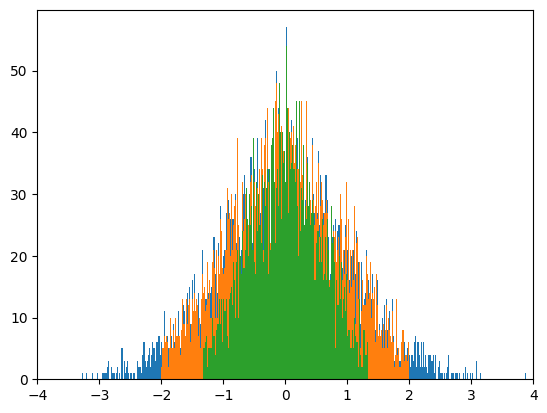

In [4]:
rand_nums = torch.randn(5000)
print(rand_nums.shape)
print(torch.std(rand_nums))
plt.hist(rand_nums, bins=500)
plt.hist(torch.fmod(rand_nums,2), bins=250)
plt.hist(torch.fmod(rand_nums,2.)*(2./3.), bins=250)
plt.xlim([-4, 4])
plt.show()

In [5]:
# importing libraries 
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [6]:
df_train = pd.read_csv(r'datasets\Grambedding\train.csv', header=None, on_bad_lines='warn', encoding = 'ISO-8859-1', low_memory=False)
df_train.dropna(inplace=True)
df_train.columns = ['label', 'text']
df_train.label -= 1
df_test = pd.read_csv(r'datasets\Grambedding\test.csv', header=None, on_bad_lines='warn', encoding = 'ISO-8859-1', low_memory=False)
df_test.dropna(inplace=True)
df_test.columns = ['label', 'text']
df_test.label -= 1

df = pd.concat([df_train, df_test], axis=0)
df.dropna(inplace=True)
class_list = df.label.unique()
class_id = {'benign':1, 'malicious': 0}
id_class = {1: 'benign', 0:'malicious'}

C:\Users\fardin\AppData\Local\Temp\ipykernel_23756\3619570887.py:1: ParserWarning: Skipping line 7: expected 2 fields, saw 3
Skipping line 69227: expected 2 fields, saw 3
Skipping line 82729: expected 2 fields, saw 3
Skipping line 161388: expected 2 fields, saw 3
Skipping line 293847: expected 2 fields, saw 3
Skipping line 334928: expected 2 fields, saw 3
Skipping line 456118: expected 2 fields, saw 3

  df_train = pd.read_csv(r'datasets\Grambedding\train.csv', header=None, on_bad_lines='warn', encoding = 'ISO-8859-1', low_memory=False)
C:\Users\fardin\AppData\Local\Temp\ipykernel_23756\3619570887.py:5: ParserWarning: Skipping line 9533: expected 2 fields, saw 3
Skipping line 158818: expected 2 fields, saw 3

  df_test = pd.read_csv(r'datasets\Grambedding\test.csv', header=None, on_bad_lines='warn', encoding = 'ISO-8859-1', low_memory=False)


In [7]:
df.columns

Index(['label', 'text'], dtype='object')

In [8]:
# df = pd.read_csv(dataset_dir, on_bad_lines='warn', encoding = 'ISO-8859-1', low_memory=False)[['domain','label']]
# df.columns=['text', 'Topic']
# df.dropna(inplace=True)
# class_list = df.Topic.unique()
# class_id = {'benign':0, 'phishing': 1}
# id_class = {0: 'benign', 1:'phishing'}
# df['label'] = np.array([t for t in df['Topic']], dtype=int)
# df = df.drop('Topic', axis=1)
# df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True)
# print(df_train.label.value_counts())
# print(df_test.label.value_counts())

In [9]:
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=64, padding='max_length')

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/639986 [00:00<?, ? examples/s]

Map:   0%|          | 0/159996 [00:00<?, ? examples/s]

In [12]:
# Set the format for PyTorch
train_dataset = train_dataset.rename_column('label', 'labels')
test_dataset = test_dataset.rename_column('label', 'labels')
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [20]:
training_args = TrainingArguments(
    output_dir=r'logs/OtherModels/bert_ag_results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    overwrite_output_dir=True,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=3,
    save_strategy="no"
)

# Load the metrics
import evaluate;
accuracy_metric = evaluate.load('accuracy', trust_remote_code=True)
precision_metric = evaluate.load('precision', trust_remote_code=True)
recall_metric = evaluate.load('recall', trust_remote_code=True)

def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [21]:
torch.cuda.empty_cache()
import gc
gc.collect()

1570

In [22]:
# Train the model
# trainer.train(resume_from_checkpoint=r"logs/OtherModels/bert_ag_results/last_epoch")
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

  0%|          | 0/25000 [00:00<?, ?it/s]

{'loss': 0.1548, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.2}
{'loss': 0.0824, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.4}
{'loss': 0.0724, 'learning_rate': 1.88e-05, 'epoch': 0.6}
{'loss': 0.0638, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.8}
{'loss': 0.0595, 'learning_rate': 1.8e-05, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.056943971663713455, 'eval_accuracy': 0.97931198279957, 'eval_precision': 0.9796275563389851, 'eval_recall': 0.97931198279957, 'eval_runtime': 170.4527, 'eval_samples_per_second': 938.653, 'eval_steps_per_second': 3.667, 'epoch': 1.0}
{'loss': 0.0466, 'learning_rate': 1.76e-05, 'epoch': 1.2}
{'loss': 0.046, 'learning_rate': 1.72e-05, 'epoch': 1.4}
{'loss': 0.0447, 'learning_rate': 1.6800000000000002e-05, 'epoch': 1.6}
{'loss': 0.0427, 'learning_rate': 1.64e-05, 'epoch': 1.8}
{'loss': 0.0415, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.046376314014196396, 'eval_accuracy': 0.9836058401460036, 'eval_precision': 0.9836548145339405, 'eval_recall': 0.9836058401460036, 'eval_runtime': 170.695, 'eval_samples_per_second': 937.321, 'eval_steps_per_second': 3.662, 'epoch': 2.0}
{'loss': 0.0293, 'learning_rate': 1.5600000000000003e-05, 'epoch': 2.2}
{'loss': 0.0301, 'learning_rate': 1.5200000000000002e-05, 'epoch': 2.4}
{'loss': 0.0292, 'learning_rate': 1.48e-05, 'epoch': 2.6}
{'loss': 0.031, 'learning_rate': 1.4400000000000001e-05, 'epoch': 2.8}
{'loss': 0.0307, 'learning_rate': 1.4e-05, 'epoch': 3.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.04816111549735069, 'eval_accuracy': 0.9845496137403436, 'eval_precision': 0.9845500062454735, 'eval_recall': 0.9845496137403436, 'eval_runtime': 170.3553, 'eval_samples_per_second': 939.19, 'eval_steps_per_second': 3.669, 'epoch': 3.0}
{'loss': 0.0208, 'learning_rate': 1.3600000000000002e-05, 'epoch': 3.2}
{'loss': 0.0204, 'learning_rate': 1.3200000000000002e-05, 'epoch': 3.4}
{'loss': 0.0213, 'learning_rate': 1.2800000000000001e-05, 'epoch': 3.6}
{'loss': 0.0208, 'learning_rate': 1.2400000000000002e-05, 'epoch': 3.8}
{'loss': 0.021, 'learning_rate': 1.2e-05, 'epoch': 4.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.0529664047062397, 'eval_accuracy': 0.9847058676466912, 'eval_precision': 0.9847058846879845, 'eval_recall': 0.9847058676466912, 'eval_runtime': 170.2044, 'eval_samples_per_second': 940.023, 'eval_steps_per_second': 3.672, 'epoch': 4.0}
{'loss': 0.0142, 'learning_rate': 1.16e-05, 'epoch': 4.2}
{'loss': 0.0135, 'learning_rate': 1.1200000000000001e-05, 'epoch': 4.4}
{'loss': 0.0144, 'learning_rate': 1.0800000000000002e-05, 'epoch': 4.6}
{'loss': 0.0138, 'learning_rate': 1.04e-05, 'epoch': 4.8}
{'loss': 0.0148, 'learning_rate': 1e-05, 'epoch': 5.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.056854747235774994, 'eval_accuracy': 0.985587139678492, 'eval_precision': 0.9855947165488956, 'eval_recall': 0.985587139678492, 'eval_runtime': 162.8526, 'eval_samples_per_second': 982.459, 'eval_steps_per_second': 3.838, 'epoch': 5.0}
{'loss': 0.0096, 'learning_rate': 9.600000000000001e-06, 'epoch': 5.2}
{'loss': 0.0098, 'learning_rate': 9.200000000000002e-06, 'epoch': 5.4}
{'loss': 0.0097, 'learning_rate': 8.8e-06, 'epoch': 5.6}
{'loss': 0.0105, 'learning_rate': 8.400000000000001e-06, 'epoch': 5.8}
{'loss': 0.0108, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.06325827538967133, 'eval_accuracy': 0.9855496387409686, 'eval_precision': 0.9855557582633843, 'eval_recall': 0.9855496387409686, 'eval_runtime': 163.3076, 'eval_samples_per_second': 979.722, 'eval_steps_per_second': 3.827, 'epoch': 6.0}
{'loss': 0.0062, 'learning_rate': 7.600000000000001e-06, 'epoch': 6.2}
{'loss': 0.0074, 'learning_rate': 7.2000000000000005e-06, 'epoch': 6.4}
{'loss': 0.0073, 'learning_rate': 6.800000000000001e-06, 'epoch': 6.6}
{'loss': 0.0068, 'learning_rate': 6.4000000000000006e-06, 'epoch': 6.8}
{'loss': 0.0067, 'learning_rate': 6e-06, 'epoch': 7.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.07270927727222443, 'eval_accuracy': 0.9856308907722693, 'eval_precision': 0.9856329069325611, 'eval_recall': 0.9856308907722693, 'eval_runtime': 162.9797, 'eval_samples_per_second': 981.693, 'eval_steps_per_second': 3.835, 'epoch': 7.0}
{'loss': 0.005, 'learning_rate': 5.600000000000001e-06, 'epoch': 7.2}
{'loss': 0.0055, 'learning_rate': 5.2e-06, 'epoch': 7.4}
{'loss': 0.0048, 'learning_rate': 4.800000000000001e-06, 'epoch': 7.6}
{'loss': 0.0052, 'learning_rate': 4.4e-06, 'epoch': 7.8}
{'loss': 0.0053, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.07957855612039566, 'eval_accuracy': 0.9851621290532263, 'eval_precision': 0.9851622385234298, 'eval_recall': 0.9851621290532264, 'eval_runtime': 162.8906, 'eval_samples_per_second': 982.23, 'eval_steps_per_second': 3.837, 'epoch': 8.0}
{'loss': 0.004, 'learning_rate': 3.6000000000000003e-06, 'epoch': 8.2}
{'loss': 0.0037, 'learning_rate': 3.2000000000000003e-06, 'epoch': 8.4}
{'loss': 0.0038, 'learning_rate': 2.8000000000000003e-06, 'epoch': 8.6}
{'loss': 0.0039, 'learning_rate': 2.4000000000000003e-06, 'epoch': 8.8}
{'loss': 0.0036, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.08697407692670822, 'eval_accuracy': 0.9857996449911248, 'eval_precision': 0.9858045424494104, 'eval_recall': 0.9857996449911248, 'eval_runtime': 163.0616, 'eval_samples_per_second': 981.199, 'eval_steps_per_second': 3.833, 'epoch': 9.0}
{'loss': 0.0028, 'learning_rate': 1.6000000000000001e-06, 'epoch': 9.2}
{'loss': 0.003, 'learning_rate': 1.2000000000000002e-06, 'epoch': 9.4}
{'loss': 0.0025, 'learning_rate': 8.000000000000001e-07, 'epoch': 9.6}
{'loss': 0.0026, 'learning_rate': 4.0000000000000003e-07, 'epoch': 9.8}
{'loss': 0.0028, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.08967098593711853, 'eval_accuracy': 0.9858308957723944, 'eval_precision': 0.9858352321445689, 'eval_recall': 0.9858308957723942, 'eval_runtime': 163.0296, 'eval_samples_per_second': 981.392, 'eval_steps_per_second': 3.834, 'epoch': 10.0}
{'train_runtime': 15224.5774, 'train_samples_per_second': 420.364, 'train_steps_per_second': 1.642, 'train_loss': 0.022460230932235717, 'epoch': 10.0}


  0%|          | 0/625 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.08967098593711853, 'eval_accuracy': 0.9858308957723944, 'eval_precision': 0.9858352321445689, 'eval_recall': 0.9858308957723942, 'eval_runtime': 163.3287, 'eval_samples_per_second': 979.595, 'eval_steps_per_second': 3.827, 'epoch': 10.0}


In [23]:
trainer.save_model(r"logs/OtherModels/distilbert_grambedding_results/last_epoch")

In [33]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torchmetrics.classification import ConfusionMatrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def calculate_metrics(bert_model):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    bert_model = bert_model.eval()
    bert_model.to(device)
    for _ in tqdm(test_dataset):
        X = _['input_ids'].unsqueeze(0).to(device)
        msk = _['attention_mask'].unsqueeze(0).to(device)
        y = _['labels'].to(device)
        with torch.no_grad():
            y_p = bert_model(X, attention_mask=msk).logits
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    return y_pred, y_true
    y_pred = torch.cat(y_pred, dim=0)
    # y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    y_pred2 = torch.argmax(y_pred, dim=1)
    # y_true2 = torch.argmax(y_true, dim=1)
    y_true2 = y_true
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [28]:
trainer.model(test_dataset[0]['input_ids'].unsqueeze(0).to(device), attention_mask=test_dataset[0]['attention_mask'].unsqueeze(0).to(device)).logits

tensor([[-5.1260,  6.5161]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [34]:
y_pred, y_true = calculate_metrics(trainer.model)

  0%|          | 0/159996 [00:00<?, ?it/s]

100%|██████████| 159996/159996 [46:33<00:00, 57.28it/s] 


In [56]:
y_pred

tensor([[-5.1260,  6.5161],
        [-5.2008,  6.2141],
        [ 6.8535, -7.7030],
        ...,
        [-5.5135,  6.7213],
        [ 6.6492, -7.5064],
        [-4.0169,  5.2082]])

In [57]:
cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))
print(f'classification report: \n {classification_report(y_true, torch.argmax(y_pred, dim=1), digits=4)}')
print(f'confusion matrix:\n {cm(y_pred, y_true)}')

classification report: 
               precision    recall  f1-score   support

           0     0.9873    0.9843    0.9858     79998
           1     0.9844    0.9873    0.9859     79998

    accuracy                         0.9858    159996
   macro avg     0.9858    0.9858    0.9858    159996
weighted avg     0.9858    0.9858    0.9858    159996

confusion matrix:
 tensor([[78745,  1253],
        [ 1014, 78984]])


In [48]:
torch.argmax(y_pred, dim=1).shape

torch.Size([159996])

In [ ]:
Evaluation results: {'eval_loss': 0.07060451805591583, 'eval_accuracy': 0.9905251842751843, 'eval_precision': 0.9877763381021575, 'eval_recall': 0.9839378848819438, 'eval_runtime': 300.514, 'eval_samples_per_second': 216.695, 'eval_steps_per_second': 8.668, 'epoch': 5.0}


In [1]:
p = 0.9877763381021575
r = 0.9839378848819438
(2*p*r)/(p+r)

0.9858533752195847

In [19]:
calculate_flops(model, input_shape=(2, 64), transformer_tokenizer=tokenizer)

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2654: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  66.96 M 
fwd MACs:                                                               5.51 GMACs
fwd FLOPs:                                                              11.03 GFLOPS
fwd+bwd MACs:                                                           16.54 GMACs
fwd+bwd FLOPs:                                                          33.1 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacul

('11.03 GFLOPS', '5.51 GMACs', '66.96 M')

In [11]:
from transformers import DistilBertTokenizer, DistilBertModel
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, max_length=64, truncation=True, padding='max_length', return_tensors='pt')
output = model(**encoded_input)
flopt_counter = FlopCounterMode(model)
with flopt_counter:
    model(**encoded_input)

Module                                                    FLOP    % Total
---------------------------------------------------  ---------  ---------
DistilBertForSequenceClassification                  5512.501M    100.00%
 - aten.addmm                                        5437.004M     98.63%
 - aten.bmm                                            75.497M      1.37%
 DistilBertForSequenceClassification.distilbert      5511.315M     99.98%
  - aten.addmm                                       5435.818M     98.61%
  - aten.bmm                                           75.497M      1.37%
 DistilBertForSequenceClassification.pre_classifier     1.180M      0.02%
  - aten.addmm                                          1.180M      0.02%
 DistilBertForSequenceClassification.classifier         0.006M      0.00%
  - aten.addmm                                          0.006M      0.00%
